# $$\text{WEATHER - SEOUL}$$
### $$\textbf{Analiza danych rzeczywistych przy pomocy modelu ARMA}$$

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acovf

## 1. Wstęp

    1.1. Czy w analizowanych danych występują braki?

In [4]:
# BOSTON
data = pd.read_csv('boston.csv')
data['time'] = pd.to_datetime(data['time'])
data.isnull().sum()

time      0
tavg      1
tmin      0
tmax      0
prcp      0
wdir    587
wspd      0
pres    161
dtype: int64

- uzupełnienie braków - średnia temperatura z dnia poprzedniego i dnia następnego

In [5]:
data['tavg'] = data['tavg'].replace('', np.nan)
missing_index = data[data['tavg'].isnull()].index[0]

data.head(missing_index+1)

,time,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2013-03-01,3.2,1.1,5.0,0.0,342.0,15.1,1002.7
1,2013-03-02,3.1,1.1,5.6,0.0,307.0,14.4,1004.2
2,2013-03-03,2.6,0.6,6.1,0.0,NaN,14.4,1002.6
3,2013-03-04,1.8,-0.6,5.0,0.0,303.0,28.1,1003.0
4,2013-03-05,2.9,0.0,6.1,0.0,NaN,16.6,1013.5
5,2013-03-06,3.2,1.7,5.0,1.3,58.0,36.7,1018.5
6,2013-03-07,0.4,-1.1,2.8,11.7,20.0,38.2,1016.5
7,2013-03-08,0.4,-2.2,5.6,23.9,9.0,29.5,1016.3
8,2013-03-09,1.8,-0.6,3.3,0.0,35.0,17.6,1024.3
9,2013-03-10,NaN,-2.2,2.8,0.0,NaN,12.6,NaN


In [6]:
prev_day = data['tavg'].iloc[missing_index - 1]
next_day = data['tavg'].iloc[missing_index + 1]
data.at[missing_index, 'tavg'] = (prev_day + next_day) / 2

data.head(missing_index+1)

,time,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2013-03-01,3.2,1.1,5.0,0.0,342.0,15.1,1002.7
1,2013-03-02,3.1,1.1,5.6,0.0,307.0,14.4,1004.2
2,2013-03-03,2.6,0.6,6.1,0.0,NaN,14.4,1002.6
3,2013-03-04,1.8,-0.6,5.0,0.0,303.0,28.1,1003.0
4,2013-03-05,2.9,0.0,6.1,0.0,NaN,16.6,1013.5
5,2013-03-06,3.2,1.7,5.0,1.3,58.0,36.7,1018.5
6,2013-03-07,0.4,-1.1,2.8,11.7,20.0,38.2,1016.5
7,2013-03-08,0.4,-2.2,5.6,23.9,9.0,29.5,1016.3
8,2013-03-09,1.8,-0.6,3.3,0.0,35.0,17.6,1024.3
9,2013-03-10,3.3,-2.2,2.8,0.0,NaN,12.6,NaN


    1.2. Czy badany zbiór danych zawiera informacje ze wszystkich dni z zakresu od 2013-03-01 do 2023-03-01 (tzn. 'równe oddalenie w czasie')?

In [7]:
data_copy = data.copy()

In [8]:
#BOSTON
data_copy['time'] = pd.to_datetime(data_copy['time'])
data_copy.set_index('time', inplace=True)
data_copy.sort_index(inplace=True)

In [9]:
full_date_range = pd.date_range(start=data_copy.index.min(), end=data_copy.index.max(), freq='D')
missing_dates = full_date_range.difference(data_copy.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Odpowiedź brzmi tak.

    1.3. Wizualizacja danych

In [10]:
#BOSTON
data_selected = data[['time', 'tavg']]
temp = data_selected['tavg']
time = data_selected['time']
data_selected.head()

,time,tavg
0,2013-03-01,3.2
1,2013-03-02,3.1
2,2013-03-03,2.6
3,2013-03-04,1.8
4,2013-03-05,2.9


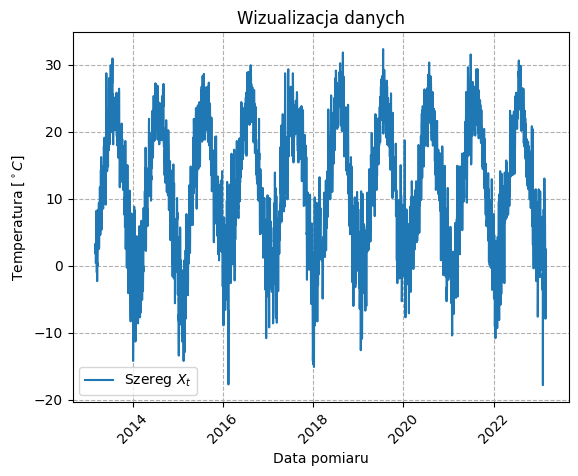

In [11]:
plt.plot(time, temp, label = 'Szereg $X_t$')
plt.grid(True, linestyle = '--')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xlabel('Data pomiaru')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Wizualizacja danych")
plt.savefig('Temperature_data.png', bbox_inches='tight')
plt.show()

## 2. Przygotowanie danych do analizy

    2.1. Jakość danych

- zakres badanych wartości

In [12]:
# minimalna i maksymalna prędkość wiatru
min_temp = np.min(temp)
max_temp = np.max(temp)

print('Minimalna prędkość wiatru w danych:', min_temp)
print('Maksymalna prędkość wiatru w danych:', max_temp)

Minimalna prędkość wiatru w danych: -17.8
Maksymalna prędkość wiatru w danych: 32.3


    2.2. Dekompozycja szeregu czasowego

-  wykres ACF oraz PACF dla surowych danych - EMPIRYCZNIE

In [13]:
def autokowariancja_emp(x, h):
    n = len(x)
    autocov = np.zeros(len(h))
    for j, hi in enumerate(h):
        if hi < n:
            autocov[j] = (1 / n) * np.sum((x[:n - hi] - np.mean(x)) * (x[hi:] - np.mean(x)))
        else:
            autocov[j] = 0
    return autocov

In [14]:
def autokorelacja_emp(x, h):
    autocov = autokowariancja_emp(x, h)
    autocov_0 = autocov[0] 
    autokor = autocov / autocov_0
    return autokor

In [15]:
def partialautocor(x, h):
    gamma_hat = autokowariancja_emp(x, h)
    pacf = np.zeros(len(h))
    pacf[0] = 1.0 
    for k in range(1, len(h)):
        gamma_matrix = np.array([[gamma_hat[abs(i - j)] for j in range(k)] for i in range(k)])
        gamma_vector = gamma_hat[1 : k + 1]
        phi_k = np.linalg.solve(gamma_matrix, gamma_vector)
        pacf[k] = phi_k[-1]
    return pacf

In [16]:
Xt = temp.values
h = 40

In [17]:
h_range = np.arange(h+1)
ACF_emp = autokorelacja_emp(x = Xt, h = h_range)
PACF_emp = partialautocor(x = Xt, h = h_range)

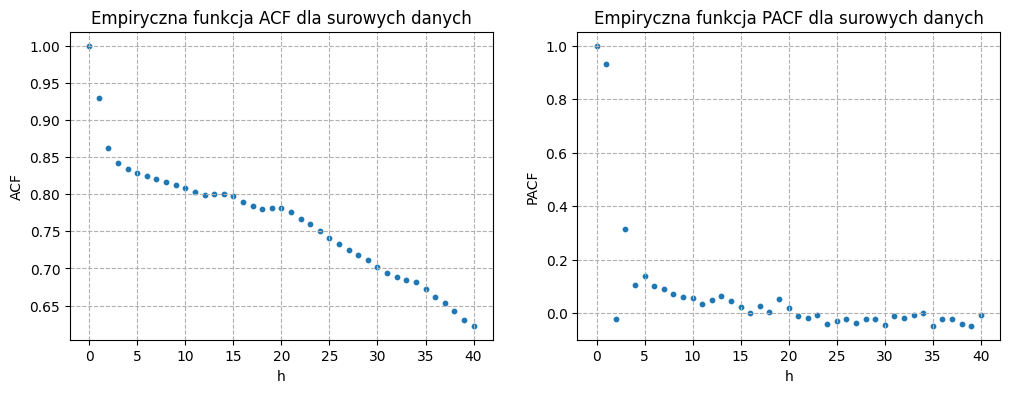

In [18]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(h_range, ACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja ACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('ACF')

plt.subplot(1,2,2)
plt.scatter(h_range, PACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja PACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('PACF')


plt.show()

-  wykres ACF oraz PACF dla surowych danych - WBUDOWANA FUNKCJA (statsmodels)

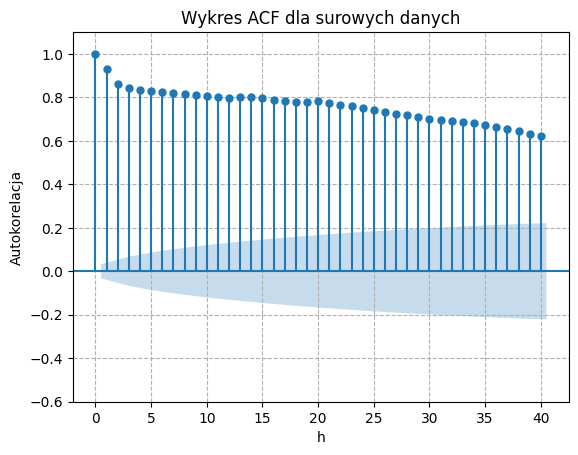

In [19]:
plot_acf(Xt, lags=h)
plt.title("Wykres ACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.ylim(-0.6,1.1)

plt.savefig('ACF_raw_data.png', bbox_inches='tight')
plt.show()

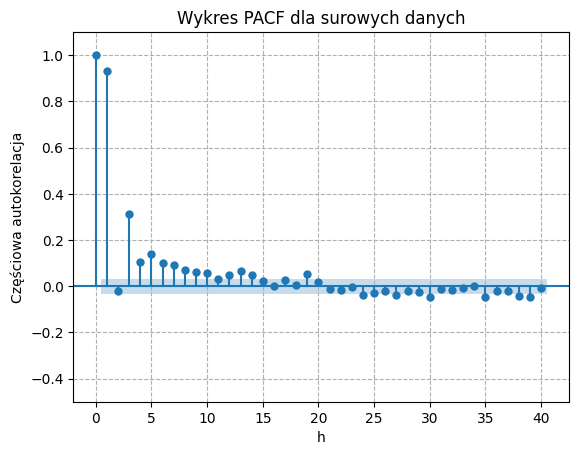

In [20]:
plot_pacf(Xt, lags=h, method='ywm')
plt.title("Wykres PACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_raw_data.png', bbox_inches='tight')
plt.show()


    2.3. (*opcjonalne) Testowanie stacjonarności - surowe dane

In [21]:
# Testowanie stacjonarności
def adfuller_test(series, sig=0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [22]:
is_Xt_stationary = adfuller_test(Xt)
is_Xt_stationary

Statystyka testowa = -3.601, p-Value = 0.006 => Stationary. 


    2.4. Identyfikacja trendów deterministycznych

$$ X_t = m(t) + s(t) + Y(t)  $$

- trend m(t)

In [23]:
n = len(Xt)
t = np.linspace(0, n, n)
m_fit = np.polyfit(t, Xt, 1)
mt = np.polyval(m_fit, t)

In [24]:
Xt_without_trend = Xt - mt

- sezonowość s(t)

In [25]:
def s_func_para(t, a, b, c):
    return a*np.sin(b*t + c)

In [26]:
a_initial = (np.max(Xt) - np.min(Xt)) / 2
b_initial = 2 * np.pi / 365
c_initial = np.pi/2
d_initial = np.mean(Xt)

params, covariance = curve_fit(s_func_para, t, Xt_without_trend, p0=[a_initial, b_initial, c_initial])

a_fit, b_fit, c_fit = params
st = s_func_para(t, a_fit, b_fit, c_fit)

In [27]:
params

array([-12.19793189,   0.01720239,   2.13821696])

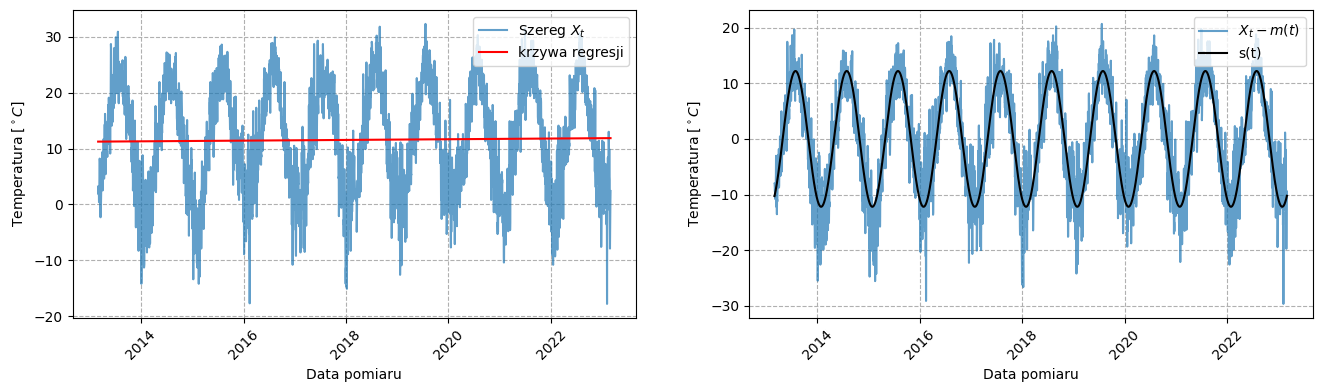

In [28]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(time, Xt, alpha = 0.7, label = 'Szereg $X_t$')
plt.plot(time, mt, color = 'red', label = 'krzywa regresji')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.subplot(1,2,2)
plt.plot(time, Xt_without_trend, alpha = 0.7, label = '$X_t - m(t) $')
plt.plot(time, st, color = 'black', label = 's(t)')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.savefig('decomposeXt.png', bbox_inches='tight')
plt.show()

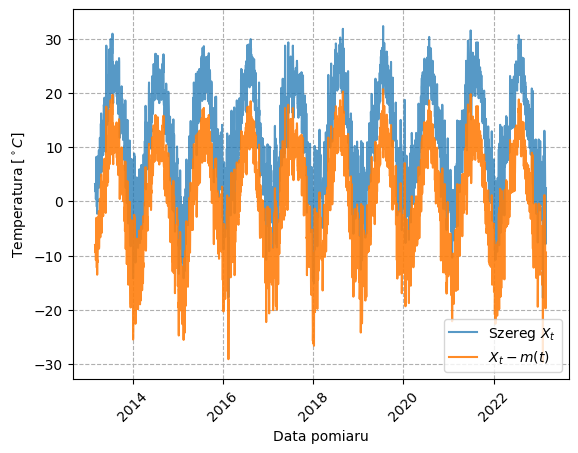

In [29]:
plt.plot(time, Xt, alpha = 0.75, label = 'Szereg $X_t$')
plt.plot(time, Xt_without_trend, alpha = 0.9, label = '$X_t - m(t)$')
plt.grid(True, linestyle='--')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend()

plt.savefig('Xt_VS_deltaXtm.png', bbox_inches='tight')
plt.show()

- Szereg czasowy liniowy $Y_t$

In [30]:
Yt = Xt - mt - st

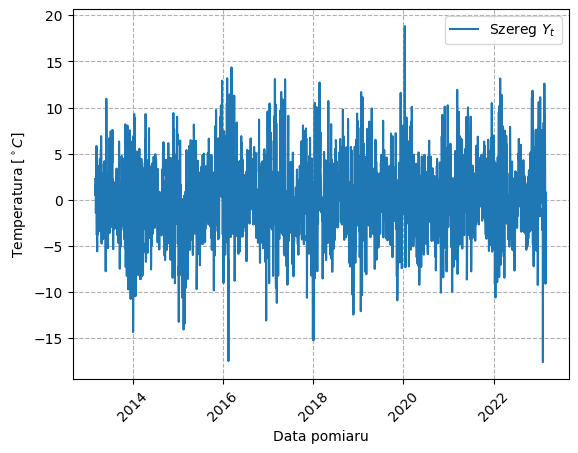

In [31]:
plt.plot(time, Yt, label = 'Szereg $Y_t$')
plt.grid(True, linestyle='--')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend()

plt.savefig('cleanYt.png', bbox_inches='tight')
plt.show()

    2.5. Wykres ACF oraz PACF dla uzyskanego szeregu

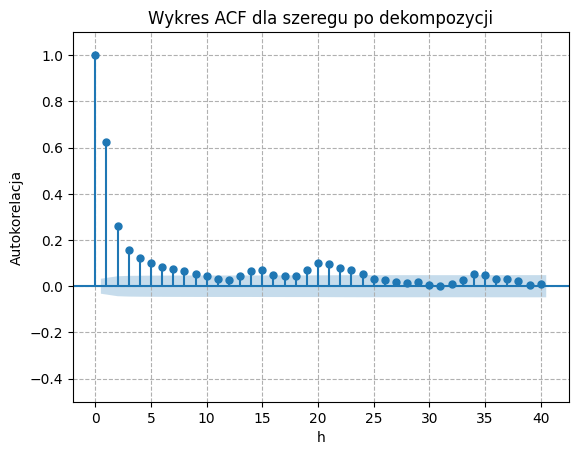

In [32]:
plot_acf(Yt, lags=h)
plt.title("Wykres ACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('ACF_data.png', bbox_inches='tight')
plt.show()

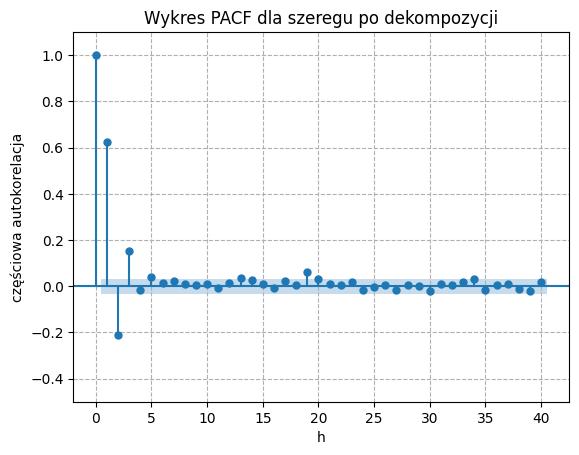

In [33]:
#zmiana: w plot_pacf podany był szereg Xt (sprzed dekompozycji)
plot_pacf(Yt, lags=h, method='ywm')
plt.title("Wykres PACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_data.png', bbox_inches='tight')
plt.show()


    2.6. (*opcjonalne) Testowanie stacjonarności - po dekompozycji

In [34]:
is_Yt_stationary = adfuller_test(Yt)
is_Yt_stationary

Statystyka testowa = -10.159, p-Value = 0.0 => Stationary. 


## 3. Modelowanie danych przy pomocy ARMA

    3.1. Dobranie rzędu modelu (kryteria informacyjne)

In [35]:
p_values = []
q_values = []
BIC = []
AIC = []
HQIC = []
df = pd.DataFrame()

max_p = 4
max_q = 4

for p in range(0, max_p):
    for q in range(0, max_q):
        
        arima_model = ARIMA(Yt, order=(p, 0, q))
        arima_model_fit = arima_model.fit()
        
        p_values.append(p)
        q_values.append(q)
        AIC.append(arima_model_fit.aic)
        BIC.append(arima_model_fit.bic)
        HQIC.append(arima_model_fit.hqic)

df['p'] = p_values
df['q'] = q_values
df['AIC'] = AIC
df['BIC'] = BIC
df['HQIC'] = HQIC


In [36]:
#posortowanie wartości wg wartości AIC (od najmniejszej)
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
10,2,2,18637.794062,18675.013886,18651.048506
11,2,3,18639.793912,18683.217040,18655.257430
14,3,2,18639.793949,18683.217077,18655.257467
15,3,3,18641.539307,18691.165740,18659.211899
7,1,3,18642.573640,18679.793464,18655.828084


In [37]:
#posortowanie wartości wg wartości BIC (od najmniejszej)
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
10,2,2,18637.794062,18675.013886,18651.048506
7,1,3,18642.573640,18679.793464,18655.828084
12,3,0,18650.986950,18682.003470,18662.032320
11,2,3,18639.793912,18683.217040,18655.257430
14,3,2,18639.793949,18683.217077,18655.257467


In [38]:
#posortowanie wartości wg wartości HQIC (od najmniejszej)
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
10,2,2,18637.794062,18675.013886,18651.048506
11,2,3,18639.793912,18683.217040,18655.257430
14,3,2,18639.793949,18683.217077,18655.257467
7,1,3,18642.573640,18679.793464,18655.828084
15,3,3,18641.539307,18691.165740,18659.211899


In [39]:
# krótka analiza dla wybranego modelu
p = 2
q = 2

fitted_model = ARIMA(Yt, order=(p, 0, q)).fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3653
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -9312.897
Date:                Sun, 26 Jan 2025   AIC                          18637.794
Time:                        22:05:17   BIC                          18675.014
Sample:                             0   HQIC                         18651.049
                               - 3653                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.180      0.047      0.963      -0.344       0.361
ar.L1          1.2533      0.043     29.056      0.000       1.169       1.338
ar.L2         -0.2879      0.030     -9.489      0.000      -0.347      -0.228
ma.L1         -0.4654      0.042    -11.152      0.000      -0.547      -0.384
ma.L2         -0.4141      0.020    -20.430      0.000      -0.454      -0.374
sigma2         9.5897      0.182     52.659      0.000       9.233       9.947
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               191.78
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.11
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

    3.2. Estymacja parametrów modelu wybraną metodą.

In [65]:
#estymacja współczynników phi modelu AR(p) metodą Yule-Walkera

def yule_walker_estimation(data, p):
    data_centered = data - np.mean(data)
    autocovariance = acovf(data_centered, fft=True)[:p+1]
    Gamma = np.array([[autocovariance[abs(i - j)] for j in range(p)] for i in range(p)])
    acovf_array = autocovariance[1:p+1]
    phi_vector = np.linalg.solve(Gamma, acovf_array)
    
    return phi_vector

In [67]:
phi_1, phi_2 = yule_walker_estimation(Yt, 2)
print("Współczynnik phi_1 = ", phi_1, ", współczynnik phi_2 = ", phi_2)

Współczynnik phi_1 =  0.7559664120339143 , współczynnik phi_2 =  -0.21043588585930614


##  4. Ocena dopasowania modelu

    4.1. Przedziały ufności dla PACF/ACF

    4.2. Porównanie linii kwantylowych z trajektorią

## 5. Weryfikacja założeń dotyczących szumu

    5.1. Założenie dot. średniej (wykres wartości resztowych / t test)

    5.2. Założenie dot. wariancji (wykres wartości resztowych / Modified Levene Test / Arch Test)

    5.3. Założenie dot. niezależności (wykres ACF/PACF dla wartości resztowych / test Ljunga-Boxa)

    5.4. Założenie dot. normalności rozkładu (dystrybuanta / gęstość / wykres kwantylowy / testy na normalność)

## 6. Podsumowanie